In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns
import os
import configs
from math import floor, ceil

from Model import Model
from PlaceInputs import PlaceInputs
from utils import *
from utils_summary_statistics import *
import configs

# Choose experiment to load

In [2]:
# Specify what you're looking at
exp = 'narrow_search_factor'
model_type = 'default'

In [3]:
if os.environ['USER'] == 'chingfang':
    engram_dir = '/Volumes/aronov-locker/Ching/barcodes/' # Local Path
elif 'SLURM_JOBID' in os.environ.keys():
    engram_dir = '/mnt/smb/locker/aronov-locker/Ching/barcodes/' # Axon Path
else:
    engram_dir = '/home/cf2794/engram/Ching/barcodes/' # Cortex Path
exp_dir = os.path.join(engram_dir, 'resolution', exp, model_type)

In [4]:
N_inp = 5000
N_bar = 5000
num_states = 100
inputs = PlaceInputs(N_inp, num_states).get_inputs()

In [5]:
load = False

In [6]:
if load:
    with open('resolution_default.p', 'rb') as f:
        summary_stats = pickle.load(f)
else:
    truncate = False
    summary_stats = {}

    for param in os.listdir(exp_dir):
        if param == '.DS_Store': continue
        dirpath = os.path.join(exp_dir, param)
        for site_spacing in os.listdir(dirpath):
            if not site_spacing.startswith('res'): continue    
            dirpath = os.path.join(exp_dir, param, site_spacing)
            for seed in os.listdir(dirpath):
                if not seed.startswith('seed'): continue
                dirpath = os.path.join(exp_dir, param, site_spacing, seed)
                _param = round(float(param), 1)
                _seed = int(seed[4:])
                _site_spacing = int(site_spacing[3:])
                if truncate and (_seed > 5 or _param > 0.6): continue
                cache_states = [0, _site_spacing, 66]

                try:
                    with open(os.path.join(dirpath, 'results.p'), 'rb') as f:
                        _results = pickle.load(f)
                except:
                    continue

                readout = np.linalg.norm(_results['narrow_reconstruct'], axis=1)
                readout /= readout.max()
                reconstruct = _results['narrow_reconstruct']
                activations = _results['narrow_acts'].copy()
                _summary_stats = get_resolution_summary_statistics(
                    readout, reconstruct, cache_states, activations,
                    inputs, _site_spacing, search_strength=_param)
                for key, _dict in _summary_stats.items():
                    n_samples = len(_dict[list(_dict.keys())[0]])
                    if key not in summary_stats.keys():
                        summary_stats[key] = _dict
                    else:
                        for nested_key in _dict.keys():
                            summary_stats[key][nested_key].extend(_dict[nested_key])

    with open('resolution_default.p', 'wb') as f:
        pickle.dump(summary_stats, f)

/share/ctn/users/cf2794/Code/barcodes/utils_summary_statistics.py:137: RuntimeWarning: invalid value encountered in greater
  n_caches_correct = np.sum(readout[cache_state_idxs] > 0.5)
/share/ctn/users/cf2794/Code/barcodes/utils_summary_statistics.py:145: RuntimeWarning: invalid value encountered in greater
  valid = np.logical_and(readout>0.5, np.isin(peak_locs, cache_states))
/share/ctn/users/cf2794/Code/barcodes/utils_summary_statistics.py:155: RuntimeWarning: invalid value encountered in true_divide
  r = reconstruct[idx]/reconstruct[idx].max()


# Identifying the Presence of a Cache

### Sensitivity/Specificity at different thresholds

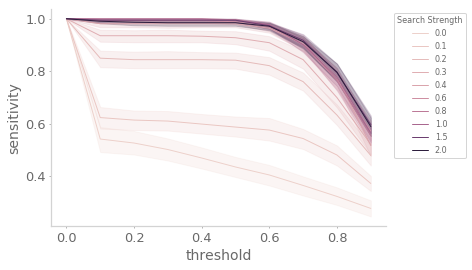

In [7]:
df = pd.DataFrame(summary_stats['identification_1'])
fig, ax = plt.subplots()
sns.lineplot(
    x='threshold', y='sensitivity', hue='search strength',
    ax=ax, data=df
    )
hue_values = df['search strength'].unique()
formatted_labels = sorted([f'{val:.1f}' for val in hue_values])
ax.legend(title='Search Strength', labels=formatted_labels, bbox_to_anchor=(1.25, 1))
plt.savefig('sensitivity.png', dpi=300)
plt.show()

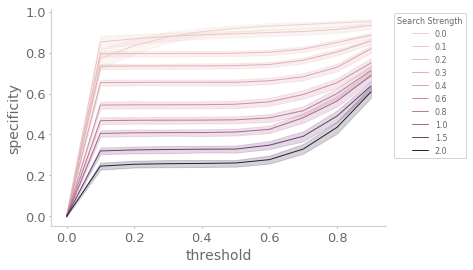

In [8]:
df = pd.DataFrame(summary_stats['identification_1'])
fig, ax = plt.subplots()
sns.lineplot(
    x='threshold', y='specificity', hue='search strength',
    ax=ax, data=df
    )
hue_values = df['search strength'].unique()
formatted_labels = sorted([f'{val:.1f}' for val in hue_values])
ax.legend(title='Search Strength', labels=formatted_labels, bbox_to_anchor=(1.25, 1))
plt.savefig('specificity.png', dpi=300)
plt.show()

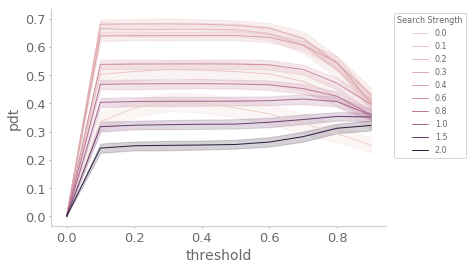

In [11]:
df = pd.DataFrame(summary_stats['identification_1'])
df['pdt'] = df['specificity'] * df['sensitivity']
fig, ax = plt.subplots()
sns.lineplot(
    x='threshold', y='pdt', hue='search strength',
    ax=ax, data=df
    )
hue_values = df['search strength'].unique()
formatted_labels = sorted([f'{val:.1f}' for val in hue_values])
ax.legend(title='Search Strength', labels=formatted_labels, bbox_to_anchor=(1.25, 1))
plt.show()

### What are the values at sites between cache 1 and cache 2?

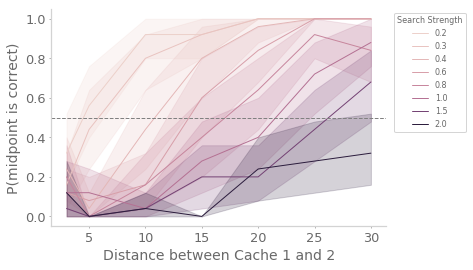

In [24]:
df = pd.DataFrame(summary_stats['identification_2'])
df['binarized'] = 1 - (df['noncache val'] > 0.5)
df = df[df['search strength'] > 0.15]
fig, ax = plt.subplots()
sns.lineplot(
    x='site spacing', y='binarized', hue='search strength',
    ax=ax, data=df)
hue_values = df['search strength'].unique()
formatted_labels = sorted([f'{val:.1f}' for val in hue_values])
ax.legend(title='Search Strength', labels=formatted_labels, bbox_to_anchor=(1.25, 1))
ax.axhline(0.5, color='gray', linestyle='--')
plt.xlabel('Distance between Cache 1 and 2')
plt.ylabel('P(midpoint is correct)')
plt.show()

### What are the values at non-caches away from a cache site?

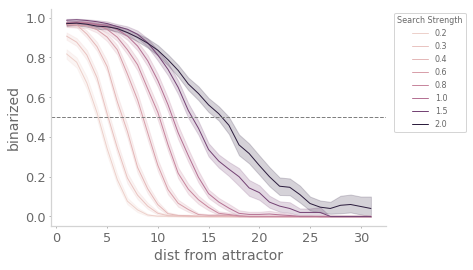

In [19]:
df = pd.DataFrame(summary_stats['identification_3'])
df = df[df['search strength'] > 0.15]
fig, ax = plt.subplots()
sns.lineplot(
    x='dist from attractor', y ='val',
    hue='search strength', data=df
    )
hue_values = df['search strength'].unique()
formatted_labels = sorted([f'{val:.1f}' for val in hue_values])
ax.legend(title='Search Strength', labels=formatted_labels, bbox_to_anchor=(1.25, 1))
ax.axhline(0.5, color='gray', linestyle='--')
plt.show()

### Performance on caches

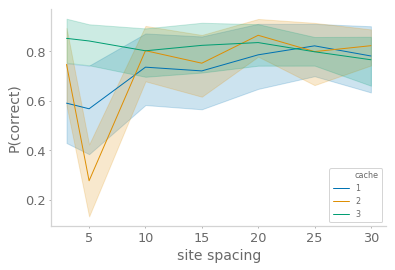

In [18]:
df = pd.DataFrame(summary_stats['identification_4'])
df = df[df['search strength'] == 0.2]
fig, ax = plt.subplots()
sns.lineplot(
    x='site spacing', y ='val',
    hue='cache', data=df, palette=['C0', 'C1', 'C2']
    )
plt.ylabel('P(correct)')
plt.show()

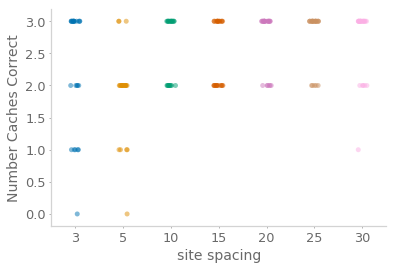

In [10]:
df = pd.DataFrame(summary_stats['identification_5'])
fig, ax = plt.subplots()
df = df[df['search strength'] == 0.2]

sns.stripplot(
    x='site spacing', y='n_caches_correct',
    data=df, alpha=0.5
    )
plt.ylabel('Number Caches Correct')
plt.show()

In [11]:
df[(df['site spacing']==3) & (df['n_caches_correct']==0)].size

3

In [12]:
df[(df['site spacing']==3) & (df['n_caches_correct']==1)].size

15

In [13]:
df[(df['site spacing']==3) & (df['n_caches_correct']==2)].size

15

In [14]:
df[(df['site spacing']==3) & (df['n_caches_correct']==3)].size

42

# Reconstruction

### Probability of valid attractor given optimal attractor distance

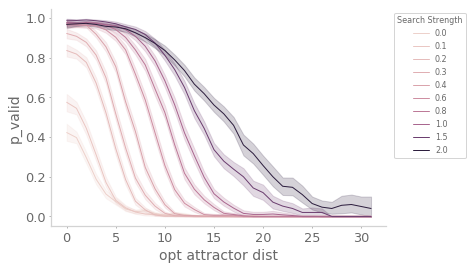

In [19]:
df = pd.DataFrame(summary_stats['reconstruct_1'])
fig, ax = plt.subplots()
sns.lineplot(
    x='opt attractor dist', y='p_valid', hue='search strength',
    data=df
    )
hue_values = df['search strength'].unique()
formatted_labels = sorted([f'{val:.1f}' for val in hue_values])
ax.legend(title='Search Strength', labels=formatted_labels, bbox_to_anchor=(1.25, 1))
plt.show()

### Conditioned on validity, what is the error?

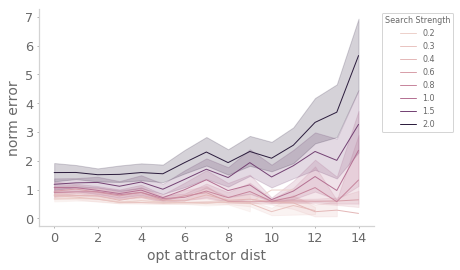

In [10]:
df = pd.DataFrame(summary_stats['reconstruct_2'])
df = df[df['search strength'] > 0.1]
df = df[df['opt attractor dist'] < 15]
fig, ax = plt.subplots()
sns.lineplot(
    x='opt attractor dist', y='norm error', hue='search strength',
    data=df
    )
hue_values = df['search strength'].unique()
formatted_labels = sorted([f'{val:.1f}' for val in hue_values])
ax.legend(title='Search Strength', labels=formatted_labels, bbox_to_anchor=(1.25, 1))
plt.show()

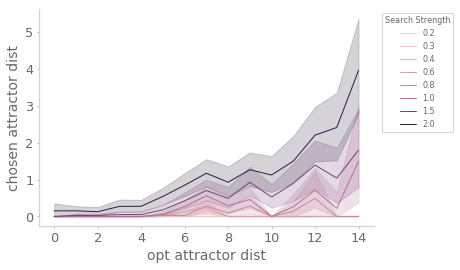

In [17]:
df = pd.DataFrame(summary_stats['reconstruct_2'])
df = df[df['site spacing']>10]
df = df[df['search strength'] > 0.1]
df = df[df['opt attractor dist'] < 15]
fig, ax = plt.subplots()
sns.lineplot(
    x='opt attractor dist', y='chosen attractor dist', hue='search strength',
    data=df
    )
hue_values = df['search strength'].unique()
formatted_labels = sorted([f'{val:.1f}' for val in hue_values])
ax.legend(title='Search Strength', labels=formatted_labels, bbox_to_anchor=(1.25, 1))
plt.show()

# Activations

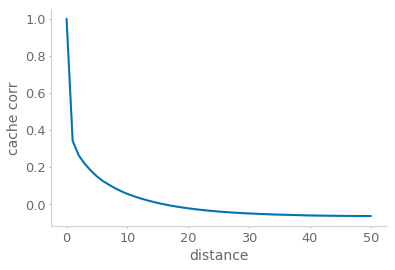

In [29]:
df = pd.DataFrame(summary_stats['activations_1'])
fig, ax = plt.subplots()
sns.lineplot(
    x='distance', y='cache corr',
    data=df, linewidth=2
    )
plt.show()